# Legendre truncation

#### Import general modules

mpi4py is always required when using these tools. Numpy is always good to have if any manipulation is to be done.

In [1]:
# Import required modules
from mpi4py import MPI #equivalent to the use of MPI_init() in C
import matplotlib.pyplot as plt
import numpy as np

# Get mpi info
comm = MPI.COMM_WORLD

import os
os.environ["PYSEMTOOLS_DEBUG"] = 'false'
os.environ["PYSEMTOOLS_HIDE_LOG"] = 'false'

#### Import modules from pysemtools

In this case we will import all the data types that we currently support, as well as io functions that are required to populate them.

In [2]:
# Data types
from pysemtools.datatypes.msh import Mesh
from pysemtools.datatypes.coef import Coef
from pysemtools.datatypes.field import Field, FieldRegistry

# Readers
from pysemtools.io.ppymech.neksuite import preadnek, pynekread

# Writers
from pysemtools.io.ppymech.neksuite import pwritenek, pynekwrite

fname = '../data/mixlay0.f00001'

## Read the data

In [3]:
# Read the data
msh = Mesh(comm, create_connectivity=False)
fld = FieldRegistry(comm)
pynekread(fname, comm, data_dtype=np.double, msh = msh, fld = fld)
 
# Get the coefficients
coef = Coef(msh=msh, comm=comm)

2025-02-26 16:25:48,037 - Mesh - INFO - Initializing empty Mesh object.
2025-02-26 16:25:48,038 - Field - INFO - Initializing empty Field object
2025-02-26 16:25:48,039 - pynekread - INFO - Reading file: ../data/mixlay0.f00001
2025-02-26 16:25:48,046 - Mesh - INFO - Initializing Mesh object from x,y,z ndarrays.
2025-02-26 16:25:48,047 - Mesh - INFO - Initializing common attributes.
2025-02-26 16:25:48,048 - Mesh - INFO - Getting vertices
2025-02-26 16:25:48,049 - Mesh - INFO - Getting edge centers
2025-02-26 16:25:48,055 - Mesh - INFO - Facet centers not available for 2D
2025-02-26 16:25:48,056 - Mesh - INFO - Mesh object initialized.
2025-02-26 16:25:48,057 - Mesh - INFO - Mesh data is of type: float64
2025-02-26 16:25:48,058 - Mesh - INFO - Elapsed time: 0.012147730000000002s
2025-02-26 16:25:48,058 - pynekread - INFO - Reading field data
2025-02-26 16:25:48,064 - pynekread - INFO - File read
2025-02-26 16:25:48,065 - pynekread - INFO - Elapsed time: 0.025218013s
2025-02-26 16:25:48,

## Compress the data with GPR

### Initialize the Direct sampler

In [4]:
from pysemtools.compression.legendre_truncation import DiscreetLegendreTruncation

# Initialize a sampler with numpy (default)
dlt = DiscreetLegendreTruncation(comm=comm, msh=msh)

# Initialize a sampler with the torch backend
dlt_torch = DiscreetLegendreTruncation(comm=comm, msh=msh, bckend='torch')


2025-02-26 16:25:48,130 - DirectSampler - INFO - Initializing the DirectSampler from a Mesh object
2025-02-26 16:25:48,136 - DirectSampler - INFO - Initializing the DirectSampler from a Mesh object


### Sample the data

In [ ]:
# Select the options
n_samples = 16+8 # To compare with the svd, since each element will save 16 coefficients
bitrate = n_samples/(msh.lx*msh.ly*msh.lz)
dlt.log.tic()
dlt.sample_field(field=fld.registry["u"], field_name="u", compression_method="fixed_bitrate", bitrate = bitrate)
dlt.log.toc()

# Keep modes to double the amount of the numpy version. Just to see any differences
n_samples = (16+8)*2  
bitrate = n_samples/(msh.lx*msh.ly*msh.lz)
dlt_torch.log.tic()
dlt_torch.sample_field(field=fld.registry["u"], field_name="u", compression_method="fixed_bitrate", bitrate = bitrate)
dlt_torch.log.toc()

2025-02-26 16:25:48,149 - DirectSampler - INFO - Sampling the field with options: covariance_method: {covariance_method}, compression_method: {compression_method}
2025-02-26 16:25:48,150 - DirectSampler - INFO - Transforming the field into to legendre space
2025-02-26 16:25:48,156 - DirectSampler - INFO - Sampling the field using the fixed bitrate method. using settings: {'method': 'fixed_bitrate', 'bitrate': np.float64(0.375), 'n_samples': 24}
2025-02-26 16:25:48,158 - DirectSampler - INFO - Sampled_field saved in field uncompressed_data["u"]["field"]
2025-02-26 16:25:48,159 - DirectSampler - INFO - Elapsed time: 0.010258076000000005s
2025-02-26 16:25:48,160 - DirectSampler - INFO - Sampling the field with options: covariance_method: {covariance_method}, compression_method: {compression_method}
2025-02-26 16:25:48,161 - DirectSampler - INFO - Transforming the field into to legendre space
2025-02-26 16:25:48,163 - DirectSampler - INFO - Sampling the field using the fixed bitrate method

### Encode it

In [6]:
dlt.compress_samples(lossless_compressor="bzip2")

dlt_torch.compress_samples(lossless_compressor="bzip2")

2025-02-26 16:25:48,181 - DirectSampler - INFO - Compressing the data using the lossless compressor: bzip2
2025-02-26 16:25:48,183 - DirectSampler - INFO - Compressing data in uncompressed_data
2025-02-26 16:25:48,184 - DirectSampler - INFO - Compressing data for field ["u"]:
2025-02-26 16:25:48,184 - DirectSampler - INFO - Compressing ["field"] for field ["u"]
2025-02-26 16:25:48,239 - DirectSampler - INFO - Compressing the data using the lossless compressor: bzip2
2025-02-26 16:25:48,240 - DirectSampler - INFO - Compressing data in uncompressed_data
2025-02-26 16:25:48,240 - DirectSampler - INFO - Compressing data for field ["u"]:
2025-02-26 16:25:48,241 - DirectSampler - INFO - Compressing ["field"] for field ["u"]


### Write it out

In [7]:
dlt.write_compressed_samples(comm=comm, filename="test")

dlt_torch.write_compressed_samples(comm=comm, filename="test_torch")

2025-02-26 16:25:48,364 - DirectSampler - INFO - Parallel HDF5 not available; creating folder to store rank files.
2025-02-26 16:25:48,369 - DirectSampler - INFO - Parallel HDF5 not available; creating folder to store rank files.


## Decompress the data

### Read the data

In [8]:
dlt_read = DiscreetLegendreTruncation(comm, filename="test")

dlt_torch_read = DiscreetLegendreTruncation(comm, filename="test_torch", bckend='torch')

2025-02-26 16:25:48,398 - DirectSampler - INFO - Initializing the DirectSampler from file: test
2025-02-26 16:25:48,444 - DirectSampler - INFO - Initializing the DirectSampler from file: test_torch


### Reconstruct the data from the samples

In [9]:
u_np= dlt_read.reconstruct_field(field_name="u")

u_d = dlt_torch_read.reconstruct_field(field_name="u")

## Visualize the data

In [10]:
# General settings

u = fld.registry["u"]
u_levels = np.linspace(np.min(u), np.max(u), 100)
err_levels = np.linspace(0, 0.5, 100)

### Numpy

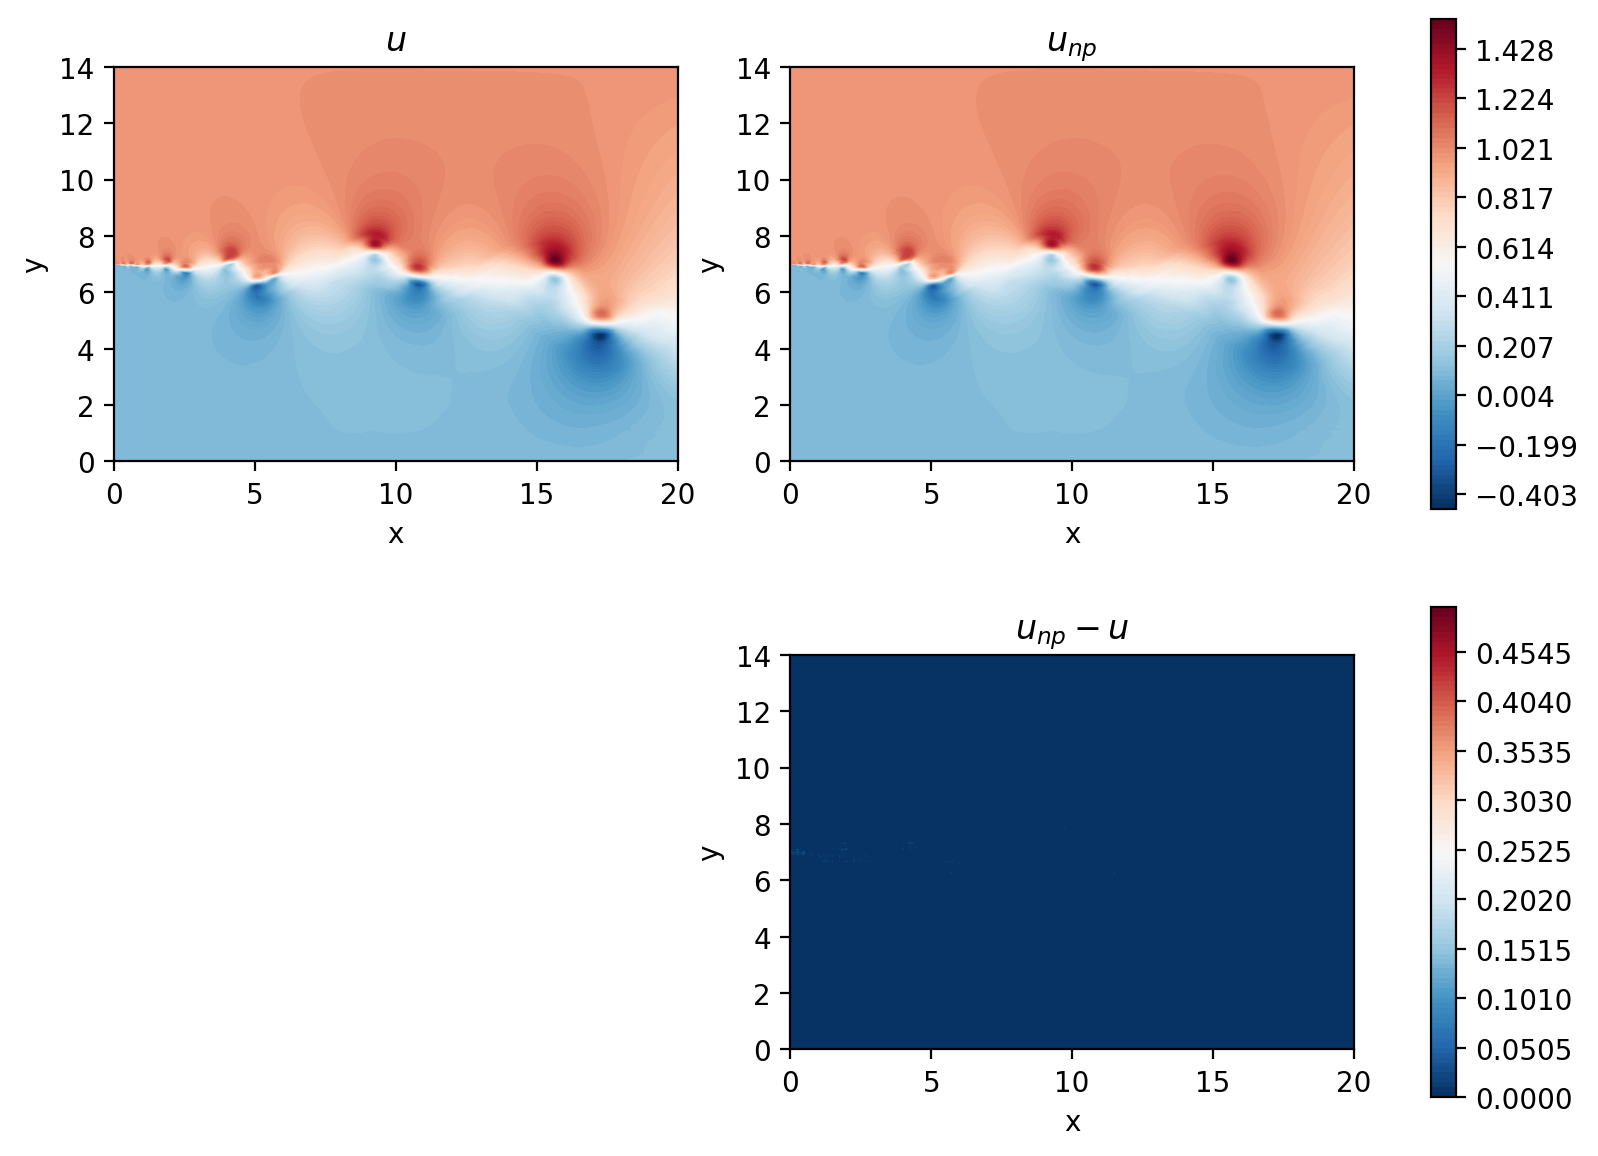

In [11]:


fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(10, 7), dpi = 200)

c00 = ax[0,0].tricontourf(msh.x.flatten(), msh.y.flatten() ,fld.registry["u"].flatten(), levels=u_levels, cmap="RdBu_r")
ax[0,0].set_aspect('equal')
ax[0,0].set_xlabel("x")
ax[0,0].set_ylabel("y")
ax[0,0].set_title(r"$u$")

c01 = ax[0,1].tricontourf(msh.x.flatten(), msh.y.flatten() ,u_np.flatten(), levels=u_levels, cmap="RdBu_r")
ax[0,1].set_aspect('equal')
ax[0,1].set_xlabel("x")
ax[0,1].set_ylabel("y")
ax[0,1].set_title(r"$u_{np}$")

ax[1, 0].axis('off')

c11 = ax[1,1].tricontourf(msh.x.flatten(), msh.y.flatten() ,np.sqrt((u_np.flatten()- u.flatten())**2), levels=err_levels, cmap="RdBu_r")
ax[1,1].set_aspect('equal')
ax[1,1].set_xlabel("x")
ax[1,1].set_ylabel("y")
ax[1,1].set_title(r"$u_{np} - u$")

cbar0=fig.colorbar(c00, ax=ax[0,:])
cbar11=fig.colorbar(c11, ax=ax[1,:])
plt.show()

### Torch

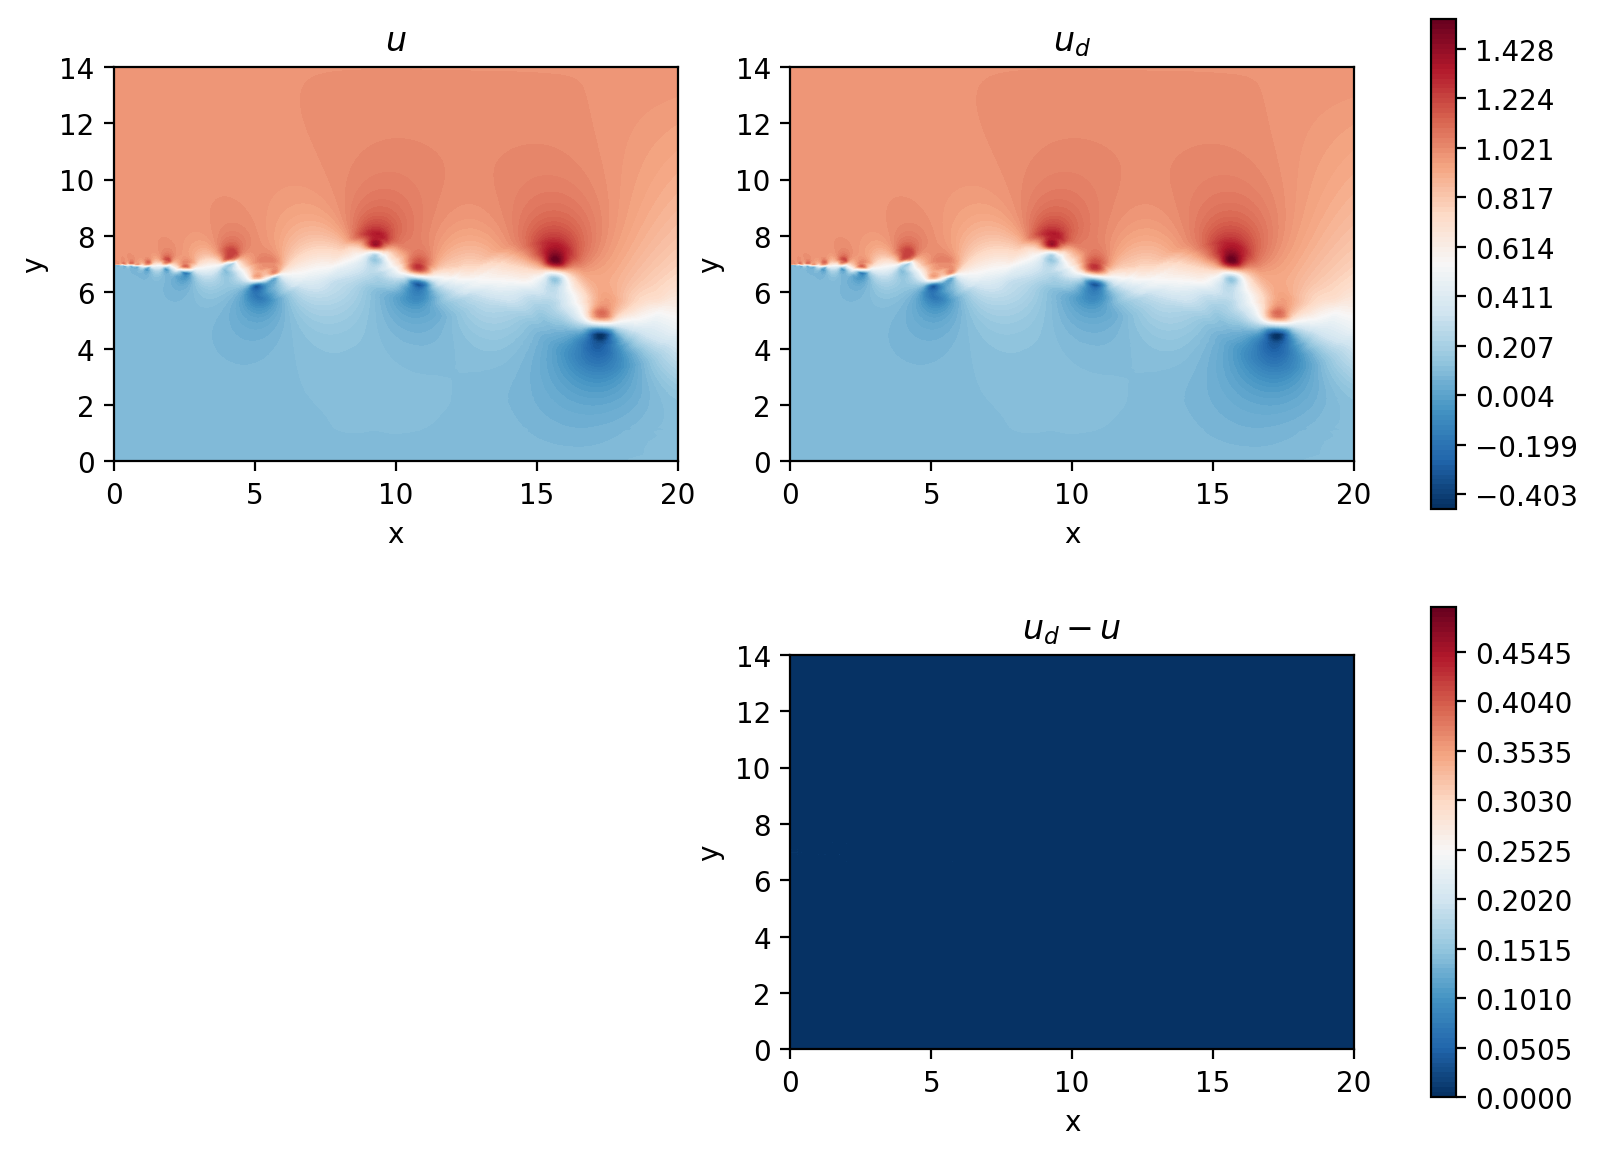

In [12]:
fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(10, 7), dpi = 200)

c00 = ax[0,0].tricontourf(msh.x.flatten(), msh.y.flatten() ,fld.registry["u"].flatten(), levels=u_levels, cmap="RdBu_r")
ax[0,0].set_aspect('equal')
ax[0,0].set_xlabel("x")
ax[0,0].set_ylabel("y")
ax[0,0].set_title(r"$u$")

c01 = ax[0,1].tricontourf(msh.x.flatten(), msh.y.flatten() ,u_d.flatten(), levels=u_levels, cmap="RdBu_r")
ax[0,1].set_aspect('equal')
ax[0,1].set_xlabel("x")
ax[0,1].set_ylabel("y")
ax[0,1].set_title(r"$u_{d}$")

ax[1, 0].axis('off')

c11 = ax[1,1].tricontourf(msh.x.flatten(), msh.y.flatten() ,np.sqrt((u_d.cpu().numpy().flatten()- u.flatten())**2), levels=err_levels, cmap="RdBu_r")
ax[1,1].set_aspect('equal')
ax[1,1].set_xlabel("x")
ax[1,1].set_ylabel("y")
ax[1,1].set_title(r"$u_{d} - u$")

cbar0=fig.colorbar(c00, ax=ax[0,:])
cbar11=fig.colorbar(c11, ax=ax[1,:])
plt.show()

## Test the derivative

In [13]:
# Initiate the mesh partitioning
from pysemtools.datatypes.msh_connectivity import MeshConnectivity

msh_conn = MeshConnectivity(comm, msh = msh, use_hashtable=True)

dudx = coef.dudxyz(u, coef.drdx, coef.dsdx)
dudy = coef.dudxyz(u, coef.drdy, coef.dsdy)

dudx_np = coef.dudxyz(u_np, coef.drdx, coef.dsdx)
dudy_np = coef.dudxyz(u_np, coef.drdy, coef.dsdy)

dudx_d = coef.dudxyz(u_d.cpu().numpy(), coef.drdx, coef.dsdx)
dudy_d = coef.dudxyz(u_d.cpu().numpy(), coef.drdy, coef.dsdy)

dudx_levels = np.linspace(-2.5, 3.1, 100)
dudy_levels = np.linspace(-4.6, 7.6, 100)

2025-02-26 16:25:57,424 - MeshConnectivity - INFO - Initializing MeshConnectivity
2025-02-26 16:25:57,425 - MeshConnectivity - INFO - Computing local connectivity
2025-02-26 16:25:57,496 - MeshConnectivity - INFO - Computing global connectivity
2025-02-26 16:25:57,498 - MeshConnectivity - INFO - Computing multiplicity
2025-02-26 16:25:57,516 - MeshConnectivity - INFO - MeshConnectivity initialized
2025-02-26 16:25:57,517 - MeshConnectivity - INFO - Elapsed time: 0.09173397499999858s
2025-02-26 16:25:57,517 - Coef - INFO - Calculating the derivative with respect to physical coordinates
2025-02-26 16:25:57,525 - Coef - INFO - done
2025-02-26 16:25:57,525 - Coef - INFO - Elapsed time: 0.007390071999999748s
2025-02-26 16:25:57,526 - Coef - INFO - Calculating the derivative with respect to physical coordinates
2025-02-26 16:25:57,534 - Coef - INFO - done
2025-02-26 16:25:57,534 - Coef - INFO - Elapsed time: 0.007833390000000051s
2025-02-26 16:25:57,535 - Coef - INFO - Calculating the deriva

### Numpy

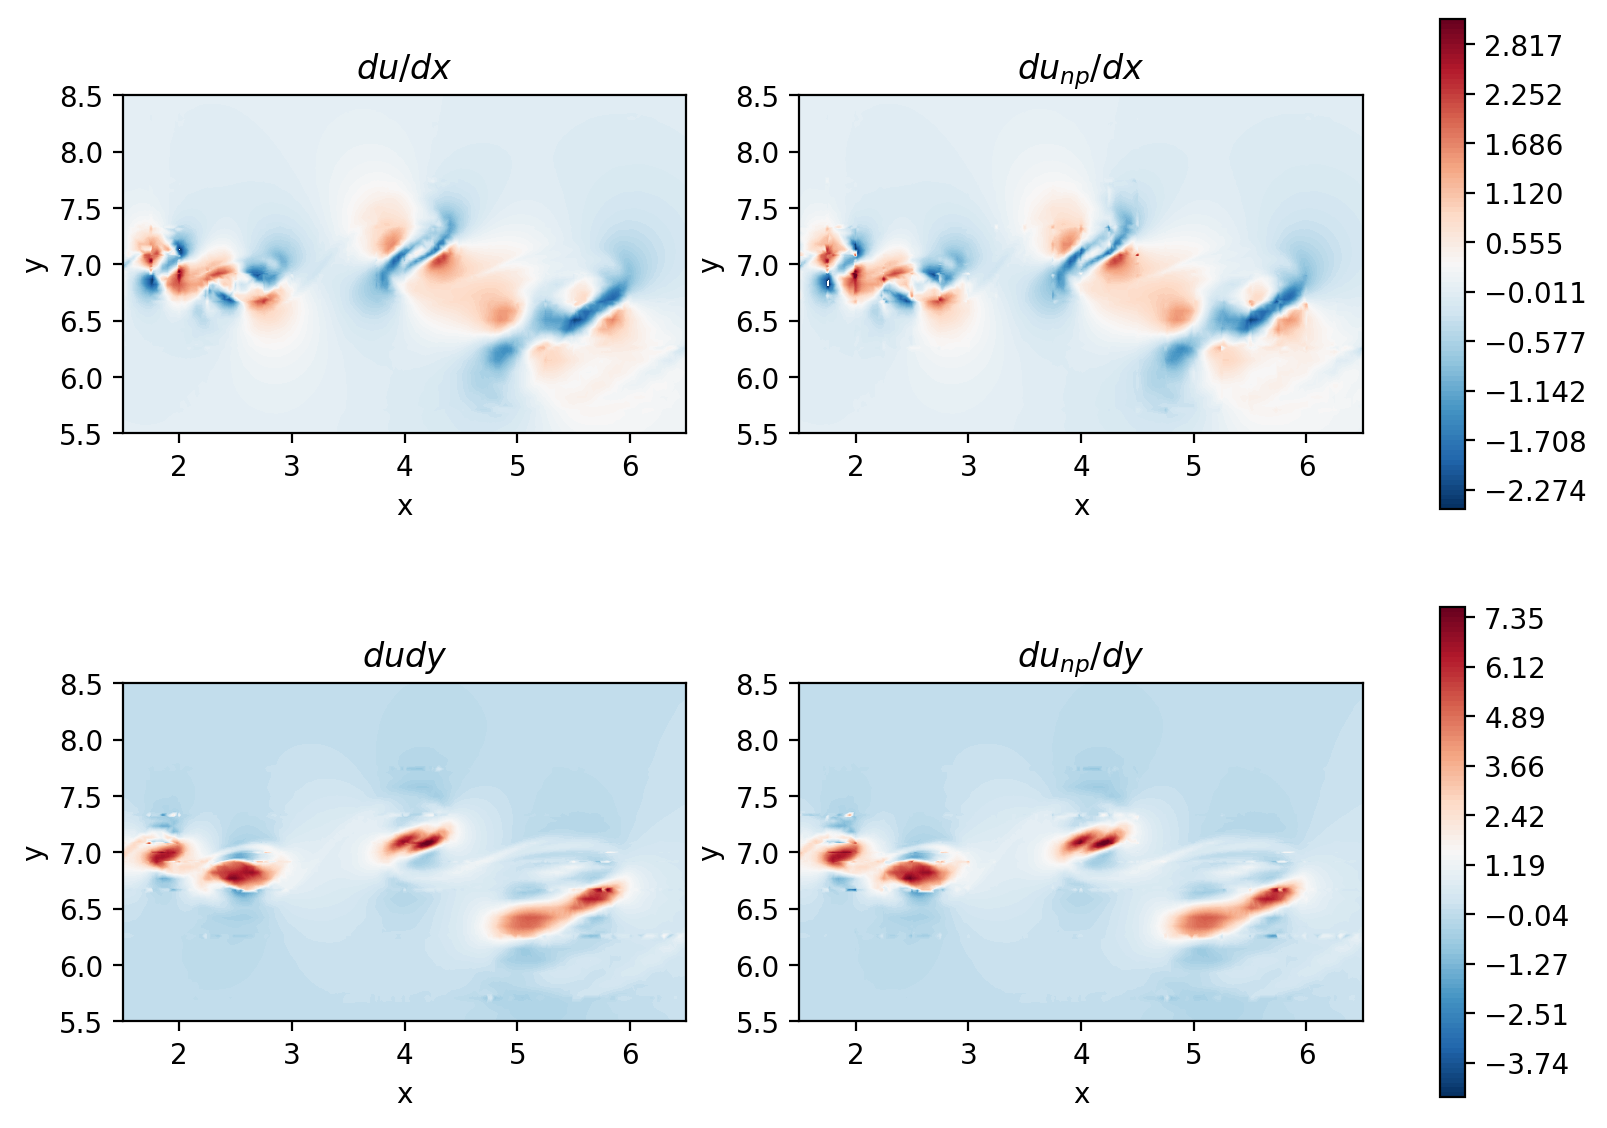

In [14]:

fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(10, 7), dpi = 200)

c00 = ax[0,0].tricontourf(msh.x.flatten(), msh.y.flatten() ,dudx.flatten(), levels=dudx_levels, cmap="RdBu_r")
ax[0,0].set_aspect('equal')
ax[0,0].set_xlabel("x")
ax[0,0].set_ylabel("y")
ax[0,0].set_title(r"$du/dx$")

c01 = ax[0,1].tricontourf(msh.x.flatten(), msh.y.flatten() ,dudx_np.flatten(), levels=dudx_levels, cmap="RdBu_r")
ax[0,1].set_aspect('equal')
ax[0,1].set_xlabel("x")
ax[0,1].set_ylabel("y")
ax[0,1].set_title(r"$du_{np}/dx$")

c10 = ax[1,0].tricontourf(msh.x.flatten(), msh.y.flatten() ,dudy.flatten(), levels=dudy_levels, cmap="RdBu_r")
ax[1,0].set_aspect('equal')
ax[1,0].set_xlabel("x")
ax[1,0].set_ylabel("y")
ax[1,0].set_title(r"$dudy$")

c11 = ax[1,1].tricontourf(msh.x.flatten(), msh.y.flatten() ,dudy_np.flatten(), levels=dudy_levels, cmap="RdBu_r")
ax[1,1].set_aspect('equal')
ax[1,1].set_xlabel("x")
ax[1,1].set_ylabel("y")
ax[1,1].set_title(r"$du_{np}/dy$")

cbar0=fig.colorbar(c00, ax=ax[0,:])
cbar10=fig.colorbar(c10, ax=ax[1,:])


ax[0,0].set_xlim([1.5,6.5])
ax[0,0].set_ylim([5.5,8.5])

ax[0,1].set_xlim([1.5,6.5])
ax[0,1].set_ylim([5.5,8.5])

ax[1,0].set_xlim([1.5,6.5])
ax[1,0].set_ylim([5.5,8.5])

ax[1,1].set_xlim([1.5,6.5])
ax[1,1].set_ylim([5.5,8.5])

plt.show()

### Torch

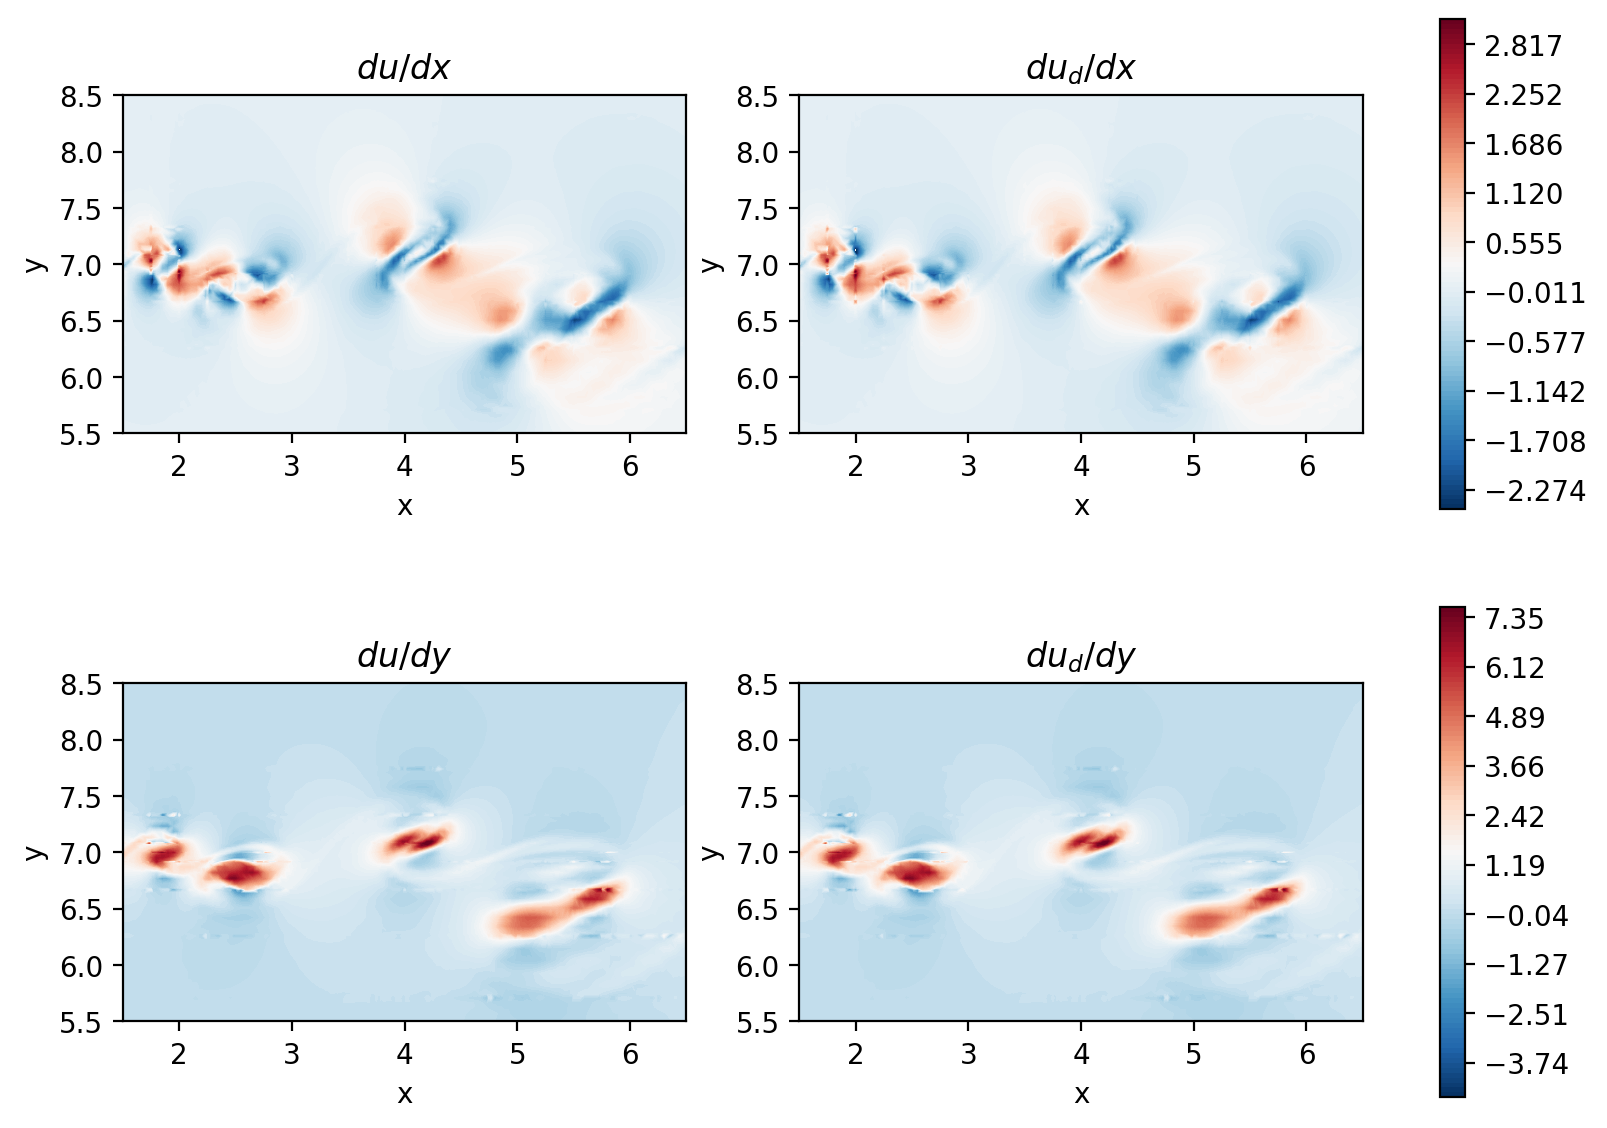

In [15]:
fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(10, 7), dpi = 200)

c00 = ax[0,0].tricontourf(msh.x.flatten(), msh.y.flatten() ,dudx.flatten(), levels=dudx_levels, cmap="RdBu_r")
ax[0,0].set_aspect('equal')
ax[0,0].set_xlabel("x")
ax[0,0].set_ylabel("y")
ax[0,0].set_title(r"$du/dx$")

c01 = ax[0,1].tricontourf(msh.x.flatten(), msh.y.flatten() ,dudx_d.flatten(), levels=dudx_levels, cmap="RdBu_r")
ax[0,1].set_aspect('equal')
ax[0,1].set_xlabel("x")
ax[0,1].set_ylabel("y")
ax[0,1].set_title(r"$du_{d}/dx$")

c10 = ax[1,0].tricontourf(msh.x.flatten(), msh.y.flatten() ,dudy.flatten(), levels=dudy_levels, cmap="RdBu_r")
ax[1,0].set_aspect('equal')
ax[1,0].set_xlabel("x")
ax[1,0].set_ylabel("y")
ax[1,0].set_title(r"$du/dy$")

c11 = ax[1,1].tricontourf(msh.x.flatten(), msh.y.flatten() ,dudy_d.flatten(), levels=dudy_levels, cmap="RdBu_r")
ax[1,1].set_aspect('equal')
ax[1,1].set_xlabel("x")
ax[1,1].set_ylabel("y")
ax[1,1].set_title(r"$du_{d}/dy$")

cbar0=fig.colorbar(c00, ax=ax[0,:])
cbar10=fig.colorbar(c10, ax=ax[1,:])


ax[0,0].set_xlim([1.5,6.5])
ax[0,0].set_ylim([5.5,8.5])

ax[0,1].set_xlim([1.5,6.5])
ax[0,1].set_ylim([5.5,8.5])

ax[1,0].set_xlim([1.5,6.5])
ax[1,0].set_ylim([5.5,8.5])

ax[1,1].set_xlim([1.5,6.5])
ax[1,1].set_ylim([5.5,8.5])

plt.show()